In [1]:
%env CUDA_VISIBLE_DEVICES=2


env: CUDA_VISIBLE_DEVICES=2


In [2]:
#-*- coding:utf-8 -*-
import os
import json
import threading
import numpy as np
from PIL import Image

import tensorflow as tf
import keras
from keras import losses
from keras import backend as K
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Reshape, Masking, Lambda, Permute
from keras.layers.recurrent import GRU, LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

from imp import reload
import densenet


Using TensorFlow backend.


In [3]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset_dir,list_IDs, labels, batch_size=32, dim=(32,32), n_channels=1,
                 characters='', shuffle=True,maxLabelLength=10):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.characters = characters
        self.n_classes = len(self.characters)
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataset_dir = dataset_dir
        self.maxLabelLength = maxLabelLength

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float)
        Y = np.zeros([self.batch_size, self.maxLabelLength],dtype=int) 
        input_length = np.zeros([self.batch_size, 1])
        label_length = np.zeros([self.batch_size, 1])
        
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            try:
                img = Image.open(os.path.join(self.dataset_dir, ID)).convert('L')
                img = img.resize((self.dim[1],self.dim[0]))
                img = np.array(img, 'f') / 255.0 - 0.5
            except (OSError,IOError) as error:
                print(error)
                img = np.zeros(*self.dim,dtype=np.float)
                

            X[i,] = np.expand_dims(img, axis=2)
            
            label_origin = self.labels[ID]
            label_origin.replace(' ','')
            label = self.__one_hot(label_origin,length=len(label_origin))


            if(len(label) <= 0):
                print("%s label len < 0" %ID)
            # the input length for ctc_loss, for densenet pool size is about 8
            label_length[i] = len(label)
            input_length[i] = self.dim[1] // 8
            Y[i, :len(label)] = label
    
            
        inputs = {'the_input': X,
            'the_labels': Y,
            'input_length': input_length,
            'label_length': label_length,
            }
        outputs = {'ctc': np.zeros([self.batch_size])}
        return inputs, outputs

    def __one_hot(self, text,length):
        length = min(length,self.maxLabelLength)
        label = np.zeros(length)
        for i, char in enumerate(text):
            index = self.characters.find(char)
            if index == -1:
                index = self.characters.find(u'.')
            if i < length:
                label[i] = index
        return label



In [4]:
import json
import sys 
sys.path.insert(0,'/mnt/wuwenhui/git_ocr_project/chinese_ocr_densenet/densenet/')
import keys


img_h = 32
img_w = 280
batch_size = 128
maxlabellength = 10


label_json_train = './images/medicine_dataset_v1/train_label.json'
label_json_valid = './images/medicine_dataset_v1/valid/valid_label.json'
with open(label_json_train,'r',encoding='utf-8') as json_file:
    label_dict_train=json.load(json_file)

with open(label_json_valid,'r',encoding='utf-8') as json_file:
    label_dict_valid=json.load(json_file)


len(label_dict_train),len(label_dict_valid)



(190965, 9912)

In [5]:
train_id = list(label_dict_train.keys())
valid_id = list(label_dict_valid.keys())
# characters = keys.alphabet[:]
characters = open('./char_std_5990.txt', 'r', encoding='utf-8').readlines()
characters = ''.join([ch.strip('\n') for ch in characters][1:] + ['卍'])
nclass = len(characters)
print(nclass)
train_generator = DataGenerator(dataset_dir='./images/medicine_dataset_v1/train/', list_IDs=train_id, 
                                labels=label_dict_train,batch_size = batch_size, characters=characters,
                                dim=(img_h,img_w),maxLabelLength=maxlabellength)
valid_generator = DataGenerator(dataset_dir='./images/medicine_dataset_v1/valid/', list_IDs=valid_id, 
                                labels=label_dict_valid,batch_size = batch_size, characters=characters,
                                dim=(img_h,img_w),maxLabelLength=maxlabellength)

5990


6
(128, 1) [  18    5  388   45  455 1618   45    5  371  241]


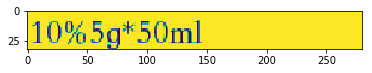

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
train_generator.on_epoch_end()
iterator = iter(train_generator)

X,y = iterator.__next__()
i = np.random.randint(0,X['the_labels'].shape[0])
# train_generator.on_epoch_end()
print(i)
print(X['input_length'].shape,X['the_labels'][i])
image = np.squeeze(X['the_input'][i])
plt.imshow(image)



In [7]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def get_model(img_h, nclass):
    input = Input(shape=(img_h, None, 1), name='the_input')
    y_pred = densenet.dense_cnn(input, nclass)

    basemodel = Model(inputs=input, outputs=y_pred)
    basemodel.summary()

    labels = Input(name='the_labels', shape=[None], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input, labels, input_length, label_length], outputs=loss_out)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam', metrics=['accuracy'])

    return basemodel, model




In [10]:

char_set = open('char_std_5990.txt', 'r', encoding='utf-8').readlines()
char_set = ''.join([ch.strip('\n') for ch in char_set][1:] + ['卍'])
nclass = len(char_set)
print(len(char_set))
# K.set_session(get_session())
reload(densenet)
basemodel, model = get_model(img_h, nclass)

modelPath = './models/weights_densenet-08-0.62.h5'
if os.path.exists(modelPath):
    print("Loading model weights...")
    basemodel.load_weights(modelPath)
    print('done!')






5990
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 32, None, 1)  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 16, None, 64) 1600        the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 16, None, 64) 256         conv2d_109[0][0]                 
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 16, None, 64) 0           batch_normalization_109[0][0]    
__________________________________________________________________________________________________
conv2

done!
<function <lambda> at 0x7f8f1e07ed08>


In [13]:


checkpoint = ModelCheckpoint(filepath='./models/weights_densenet-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=False, save_weights_only=True)
lr_schedule = lambda epoch: 0.0005 * 0.90**epoch
learning_rate = np.array([lr_schedule(i) for i in range(10)])
changelr = LearningRateScheduler(lambda epoch: float(learning_rate[epoch]))
earlystop = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./models/logs', write_graph=True)

print(lr_schedule)
print('-----------Start training-----------')
model.fit_generator(train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 100,
    initial_epoch = 0,
    validation_data = valid_generator,
    callbacks = [checkpoint, earlystop, changelr, tensorboard])


<function <lambda> at 0x7f8efb1be950>
-----------Start training-----------
Epoch 1/100
1491/1491 [==============================] - 1018s 683ms/step - loss: 0.8881 - acc: 0.8268 - val_loss: 0.6878 - val_acc: 0.8825
Epoch 2/100
1491/1491 [==============================] - 1019s 683ms/step - loss: 0.8274 - acc: 0.8368 - val_loss: 0.6650 - val_acc: 0.8809
Epoch 3/100
1491/1491 [==============================] - 1018s 683ms/step - loss: 0.7934 - acc: 0.8413 - val_loss: 0.7000 - val_acc: 0.8805
Epoch 4/100
1491/1491 [==============================] - 1020s 684ms/step - loss: 0.7535 - acc: 0.8458 - val_loss: 0.6214 - val_acc: 0.9011
Epoch 5/100
1491/1491 [==============================] - 1022s 686ms/step - loss: 0.7216 - acc: 0.8502 - val_loss: 0.6163 - val_acc: 0.8995
Epoch 6/100
1491/1491 [==============================] - 1098s 736ms/step - loss: 0.6887 - acc: 0.8545 - val_loss: 0.6165 - val_acc: 0.9045
Epoch 7/100
1491/1491 [==============================] - 1102s 739ms/step - loss: 0.6

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
label_dict_train.pop('T1058_7.png')

In [ ]:
alphabet_union = u""" ，的。一是0不在有、人“”了中国大为1:上2这个以年生和我时之也来到要会学对业出行公能他于5e3而发地可作就自们后成家日者分多下其用方本得子.高4过经6现说与前o理工所力t如将军部,事进9司场同机主都实天面市8ia新动开n关定还长此月7道美心法最文等当第好然体全比股通性重三外s但战;相从你r内无考因小资种合情去里化次入加间些度?员意没产正表很队报已名海点目着应解那看数东位题利起二民提及明教问）制期（元游女-并曰十果)么注两专样信王平己金务使电网代手知计至常(只展品更系科门特想西l水做被北由c》万老向《记政今据量保建物区管见安集或认程h总—少身先师球价空旅又求校强各非立受术基活反!世何职导任取式[]试才结费把收联直规持赛社四山统投南原该院交达接头打设每别示则调处义权台感斯证言五议d给决论她告广企格增让指研商客太息近城变技医件几书选周备m流士京传u放病华单话招路界药回再%服什改育口张需治德复准马习真语难始"际观完标共项容级即必类领AC未w型案线运历首风视色尔整质参较云具布组办气造争往形份防p它车深神称g况推越英易且营条消命团确S划精足儿局飞究功索走望却查武思兵识克故步影带乐白源史航志州限清光装节号转图根省许引势失候济显百击f器象效仅爱官包供低演连夫快续支验阳男觉花死字创素半预音户约率声请票…便构T存食y段远责M拉房随断极销林亚隐超获升B采I算益优愿找按维态满尽令汉委八终训值负境练母热适江住列举景置黄听除读众响友助弹干孩边李六甚罗致施模料火像古眼搜离D闻府章早照速录页卫青例石父状农排降千P择评疗班购属革够环占养曾米略站胜①核否独护钱/红范另须余居虽毕攻族吃喜陈G轻亲积星假b县写刘财亿某括律酒策初批普片协售乃落留岁突双绝险季谓严村E兴围依念苏底压破河怎细富切乎待室血帝君均络牌陆印层斗简讲买谈纪板希聘充归左测止笑差控担杀般朝监承播k亦临银尼介v博软欢害七良善’移土课免射审健角伊欲似配既拿刚绩密织九编狐右龙异若登检继析款纳威微域齐久宣阿俄店康执露香额紧培激卡短群②春仍伤韩楚缺洲版答O修媒秦‘错欧园减急叫诉述钟遇港补N·送托夜兰诸呢席尚福奖党坐巴毛察奇孙竞宁申L疑黑劳脑R舰晚盘征波背访互败苦阶味跟沙湾岛挥礼F词宝券虑徐患贵换矣戏艺侯顾副妇董坚含授皇付坛皆抗藏潜封础材停判吸轮守涨派彩哪笔．﹑氏尤逐冲询铁W衣绍赵弟洋午奥昨雷耳谢乡追皮句刻油误宫巨架湖固痛楼杯套恐敢H遂透薪婚困秀帮融鲁遗烈吗吴竟③惊幅温臣鲜画拥罪呼警卷松甲牛诺庭休圣馆_退莫讯渐熟肯V冠谁乱朗怪夏危码跳卖签块盖束毒杨饮届序灵怀障永顺载倒姓丽靠概输货症避寻丰操针穿延敌悉召田稳典吧犯饭握染怕端央阴胡座著损借朋救库餐堂庆忽润迎亡肉静阅盛综木疾恶享妻厂杂刺秘僧幸扩裁佳趣智促弃伯吉宜剧野附距唐释草币骨弱俱顿散讨睡探郑频船虚途旧树掌遍予梦圳森泰慢牙盟挑键阵暴脱汇歌禁浪冷艇雅迷拜旦私您④启纷哈订折累玉脚亮晋祖菜鱼醒谋姐填纸泽戒床努液咨塞遭玩津伦夺辑癌x丹荣仪献符翻估乘诚K川惠涉街诗曲孔娘怒扬闲蒙尊坦=衡迪镇沉署妖脸净哥顶掉厚魏旗兄荐童剂乏倍萨偏洗惯灭径犹趋拍档罚纯洛毫梁雨瑞宗鼓辞洞秋郎舍蓝措篮贷佛坏俗殊炮厅筑姆译摄卒谷妈聚违忘鬼触丁羽贫刑岗庄伟兼乳叶凡龄宽峰宋硬岸迅喝拟雄役零舞暗潮绿倾详税酸徒伴诊跑吾燕澳啊塔宿恩忙督末⑤+伐篇敏贸巧截沟肝迹烟勇乌赞锋返迫凭虎朱拔援搞爆勤抢敬赶抱仁秒缓御唯缩尝贴奔跨炎汤侵骑励戴肤枪植瘤埃汽羊宾替幕贝刀映彻驻披抓奉抵肿麻U炸繁赢茶伏梅狂忧豪暂贾洁绪刊忆桥晓册漫圆默妾侧址横□偶狗陵'伙杜忍薄雪陷仙恋焦焉烦甘腺颇赏肠废墙债艾杰残冒屋堡曹储莱挂纵孝珍麦逃奋J览镜缘昭摆跌胁昌耶腹偿蛋盈瓦摩沈惟迁冰辛震旁泉圈巡罢泛穷伸曼滋丈颜勒悲肥郭混灯租⑥鸡阻邑伍践驾魔X拒懂糖脏沿翁胆惧聊携晨滑菌辅贤鉴丝尾赴吨宇眠脂籍彼污貌弄郡【奶菲烧垂壮浮弗赖】珠迟渠寿隆剑胞跃稍愈荷壁卿邦忠摇悟锦扰袭盾艘浓筹盗哭淡孕扣呈怨琳孤奴驱振闭～隔寒汝贯恢饰荡姑械*猛亏锁硕舒嘉宏劲帅誉番惜胸抽脉孟遣碍辆玄陶丧矿链矛鸟夷嘴坡吕侦鸣妹邓钢妙z欣骗浙辽奏唱腐仆祝冬韦邮酬尺涯毁粉井腰肌搭恨乙勿婆★闹猎厉哀递廉卧豆揭瓶⑦蒋忌贡邀覆墓捷Q骂芳耗奈腾抑牵履绕睛炼描辉肃循仿葬漏恰殿遥尿凯仲婢胃翼卢慎厦颈哉疲惑汗衰剩昆耐疫霸赚彭狼洪枚媪纲窗偷鼻池磨尘账拼榜拨扫妆槽蔡扎叔辈―泡伪邻锡仰寸盐叹囊幼拓郁桌舟丘棋裂扶逼熊轰允箱挺赤晶●祭寄爷呆胶佩泪沃婴娱霍肾诱扁辩粗夕灾哲涂艰猪Y铜踏赫吹屈谐仔沪殷辄渡屏悦漂祸赔涛谨赐劝泌凤庙墨寺淘勃崇灰虫逆闪竹疼旨旋蒂⑧悬紫慕贪慧腿赌捉疏卜漠堪廷氧牢吏帕棒纽荒屡戈氛黎桃幽尖猫捕嫁窃燃禽稿掩踪姻陪凉阔碰幻迈铺堆柔姿膜爸斤轨疆丢仓岂柳敦祥栏邪魂箭煤惨聪艳儒&仇徽厌潘袖宅恒逻肺昂炒醉掘宪摸愤畅汪贺肪撑桂耀柏韂扑淮j凌遵钻摘碎抛匹腔纠吐滚凝插鹰郊琴悄撤驶粮辱斩暖杭齿欺殖撞颁匈翔挤乔抚泥饱劣鞋肩雇驰莲岩酷玛赠斋辨泄姬拖湿滨鹏兽锐捧尸宰舆宠胎凶割虹俊糊兹瓜悔慰浦锻削唤戚撒冯丑亭寝嫌袁⑨尉芬挖弥喊纤辟菩埋呀昏傅桑稀帐添塑赋扮芯喷夸抬旺襄岭颗柱欠逢鼎苗庸甜贼烂怜盲浅霞畏诛倡磁茨毅鲍骇峡妨雕袋裕哩怖阁函浩侍拳寡鸿眉穆狱牧拦雾猜顷昔慈朴疯苍■渴慌绳闷陕宴辖「」舜讼柯丞姚崩绘枝牲涌虔姜擦桓逊汰斥﹒颖悠恼灌q梯捐∶挣衷啡娜旬呵刷帽岳豫咖飘臂寂粒募嘱蔬苹泣吊淳诞诈咸猴~奸淫佐晰崔雍葛鼠爵奢仗涵淋挽敲沛蛇锅庞朵押鹿滩祠枕扭厘魅⑩湘柴炉荆卓碗夹脆颠窥逾诘贿虞茫榻碑傲骄卑×Z蓄煮劫卵碳痕攀搬拆谊禹窦绣叉爽肆羞爬泊腊愚牺胖弘秩娶妃柜觽躲葡浴兆滴衔燥斑挡笼徙憾垄肖溪叙茅膏甫缴姊逸淀擅催丛舌竭禅隶歧妥煌玻刃☆肚惩赂耻詹璃舱溃斜祀翰汁妄枭萄契骤醇泼咽拾廊犬筋扯狠挫钛扇蓬吞帆戎稽娃蜜庐盆胀乞堕趁吓框顽硅宛瘦剥睹烛晏巾狮辰茂○裙匆霉杖杆糟畜躁愁缠糕峻贱辣歼慨亨芝惕娇⑾渔冥咱栖浑禄帖巫喻毋泳饿尹穴沫串邹厕蒸＋滞铃寓萧弯窝杏冻愉逝诣溢嘛兮暮豹骚跪懒缝盒亩寇弊巢咬粹冤陌涕翠勾拘侨肢裸恭叛纹摊#兑萝饥>浸叟滥灿衍喘吁晒谱堵暑撰棉蔽屠讳庶巩钩丸诏朔瞬抹矢浆蜀洒耕虏诵陛绵尴坤─尬搏钙饼枯灼饶杉盼蒲尧俘伞庚摧遮痴罕桶巷乖{啦纺闯→敛弓喉酿彪垃歇圾倦狭晕裤蜂}垣莉谍俩妪⑿钓逛椅砖烤熬悼倘鸭馈惹旭薛诀渗痒蛮罩渊踢崖粟唇辐愧玲遏昼芦纣琼椎咳熙钉剖歉坠誓啤碧郅吻莎屯吟臭谦刮掠垫宙冀栗壳崛瑟哄谏丙叩缪雌叠奠髃碘暨劭霜妓厨脾俯槛芒沸盯坊咒觅剪遽贩寨铸炭绑蹈抄阎窄冈侈匿斌沾壤哨僵坎舅洽勉侣屿啼侠枢膝谒砍厢昧嫂羡铭碱棺漆睐缚谭溶烹雀擎棍瞄裹曝傻旱坑驴弦贬龟塘贞氨盎掷胺焚黏乒耍讶纱蠢掀藤蕴邯瘾婿卸斧鄙冕苑耿腻躺矩蝶浏壶凸臧墅粘⒀魄杞焰靶邵倚帘鞭僚酶靡虐阐韵迄樊畔钯菊亥嵌狄拱伺潭缆慑厮晃媚吵骃稷涅阪挨珊殆璞婉翟栋醋鹤椒囚瞒竖肴仕钦妒晴裔筛泻阙垒孰抖衬炫兢屑赦宵沮谎苟碌屁腕沦懈扉揖摔塌廖铝嘲胥曳敖傍筒朕扳鑫硝暇@冶靖袍凑悍兔邢熏株哮鹅乾鄂矶逵坟佣髓隙惭轴掏苛偃榴⒁赎谅裴缅皂淑噪阀咎揽绮瞻谜拐渭啥彦遁琐喧藉嫩寞梳溜粥恤迭瀑蓉寥彬俺忿螺膀惫扔匪毙怠彰啸荻逮删脊轩躬澡衫娥捆牡茎秉俭闺溺萍陋驳撼沽僮厥沧轿棘怡梭嗣凄℃铅绛祈斐箍爪琦惶刹嗜窜匠锤筵瑶幌捞敷酌阜哗聂絮阱膨坪歪旷翅揣樱甸颐兜頉伽绸拂狎颂谬昊皋嚷徊⒂曙麟嚣哑灞钧挪奎肇磊蕉荧嗽瓒苯躯绎鸦茵澜搅渺恕矫讽匀畴坞谥趟蔓帛寅呜枣萌磷涤蚀疮浊煎叮倩拯瑰涩绅枉朽哺邱凿莽隋炳睁澄厄惰粤黯纬哦徘炜擒捏帷攒湛夙滤浐霄豁甄剔丫愕袜呕|蹲皱勘辜唬葱甩诡猿稻宦姨橡涧亢芽濒蹄窍譬驿拢叱喂怯坝椰孽阖瞩萎镑簿婷咐郸瑜瑚矮祷窟藩牟疡仑谣侄沐孜劈枸妮蔚勋玫虾谴莹紊瓷魁淄扛曩柄滔缀闽莞恳磅耸灶埠嚼汲恍逗畸翩甥蚁耽稚戟戊侃帜璧碟敞晖匙烫眷娟卦寐苌馨锣谛桐钥琅赁蜡颤陇僻埔腥皎酝媳⒃翘缔葫吼侮淹瘫窘啖犀弒蕾偕笃栽唾陀汾俨呐膳锌瞧骏笨琢踩濮黛墟蒿歹绰捍诫漓篷咄诬乓梨奕睿嫡幢砸俞亟捣溯饵嘘砂凰丕荥赀薇滕袱辍疹泗韧撕磕梗挚挠嫉奚弩蝉罐敝鞍晦酣搁柿菠卞煞堤蟹骼晤娡潇胰酱郦脖檐桩踵禾狩盏弈牒拙喇舶炊喀黔挟钞缕俏娄粪颅锏凹饲肘赟吝襟琪谕飙秽颊渝卯捡氢桀裳滇浇礁◎蚊芙荀吩凳峨巍雉郢铲倪杳汹豚乍蛙驼嗅讫痰棵睫绒捻罔杠氟堰羁穰钠骸睾鳞邸於谧睢泾芹钾颓Ⅱ笋橘卉岐懿巅垮嵩柰鲨涡弧◆钝啃熹芭隅拌锥抒焕漳鸽烘瞪⒄箕驯恃靴刁聋剿筝绞鞅夯抉嘻弛垢衾丐斟恙雁匮娼鞠扼镶樵菇兖夭戌褚渲硫挞衙闫绾衅掣磋袒龚叨揉贻瑛俾薯憎傣炬荤烁沂粑蚌渣茄荼愍蒜菱狡蠡戍畤闵颍酋芮渎霆哼韬荫辙榄骆锂肛菑揪皖秃拽诟槐髦脓殡闾怅雯\戮澎悖嗓贮炙跋玮霖皓煽娠肋闸眩慷迂酉赘蝇羌蔑氯蚕汀憋臾汕缸棚唉棕裟蚡驮簇橙〉蹇庇佼禧崎痘芜姥绷惮雏⒅恬庵瞎臀胚嘶铀靳呻膺醛憧嫦橄褐讷趾讹鹊谯喋篡郝嗟琉逞袈鲧虢穗踰栓钊鬻羹掖笞恺掬憨狸瑕匡〈痪冢梧眺佑愣撇阏疚攘昕瓣烯谗隘酰绊鳌俟嫔崭妊雒荔毯纶祟爹辗竿裘犁柬恣阑榆翦佟钜札隧⒆腌砌酥辕铬痔讥毓橐跻酮殉哙亵锯糜壬瞭恻轲糙涿绚荟梢赣沼腑朦徇咋膊陡骋伶涓芷弋枫觑髻巳匣蠕恪槟栎噩葵殃淤诠昵眸馁奄绽闱蛛矜馔遐骡罹遑隍拭祁︰霁釜钵栾睦蚤咏憬韶圭觇芸氓伎氮靓淆绢眈掐簪搀玺镐竺峪冉拴忡卤撮胧邛彝楠缭棠腮祛棱睨嫖圉杵萃沁嬉擂澈麽轸彘褥廓狙笛彗啬盂贲忏驺悚豨旌娩扃蹦扈凛驹剃孺〕吆驷迸毗〔熔逍癸稼溥嫣瓮胱痊逡疟苻曪拣戛臻缉懊竣囤侑肽缮绥踝壑娴猝焻禀漱碁蹬祗濡挝亳萦癖彀毡锈憩筷莒噬珀砝鬓瑾澧栈恚搓褒疤沌絷镖塾钗骊拷铂郄窒驸裨矗烙惬炖赍迥蹴炽诧闰糯捅茜漯﹐峭哇鹑疵梓骠咫鹦檀痹侥蘑衢灸琵琶懦邺扪痿苔拇腋薨馅雠敕捂鴈栅瓯嘿溉胳拎巿赃咕诃谤舁禺榨–拈瘙眯篱鬟咯抨桨岱赡蹶惚嗔喏聆曜窑瘢柠蕃寤攫饷佬臼皈蟒啜蔗汶酪豕窖膛檬戾蟠黍鲸漾猾驭踊稠脯潍倭谑猖聒骞熄渍瞳蒯陉褪筐彤蝴廪嬴沱闼橱蜚蹭鄢臆邳盔眶沓飨覃彷淌岚霹辔袂嗤榔鸾綦莘媲翊雳箸蚩茸嗦楷韭簸帚坍後璋剽渤骥犊迩悯饪搂鹉岑觞棣蕊诳黥藻郜舵毂茗忱铿谙怆钳佗瀚亘铎咀濯鼾酵酯麾Ⅰ笙ü缨翳龈忒煦顼俎圃刍喙羲陨嘤梏颛蜒啮镁辇葆蔺筮溅佚匾暄谀媵纫砀悸啪迢瞽莓瞰俸珑骜穹麓潢妞铢忻铤劾樟俐缗煲粱虱淇徼脐鼋嘈悴捶嚏挛谚螃殴瘟掺〇酚梵栩褂摹蜿钮箧胫馒焱嘟芋踌圜衿峙宓腆佞砺婪瀛苷昱贰秤扒龁躇翡宥弼醮缤瘗鳖擞眨礶锢辫儋纭洼漕飓纂繇舷勺诲捺瞑啻蹙佯茹怏蛟鹭烬■兀檄浒胤踞僖卬爇璀暧髡蚂饽镰陂瞌诽钺沥镍耘燎祚儣莺屎辘鸥驩氐匕銮━苴憔渥袅瞿瓢痣蘸蹑玷惺轧喃潺唏逅懵帏唠徨咤抠蛊苇铮疙闳砥羸遨哎捽钏壹昇擢贽汴砰牝蔼熠粽绌杼麒叭颔锭妍姒邂濞轶搔蹊阂垦猕伫瘩璐黠婺噫潞呱幡汞缯骁墩赧瞥媛瞠羔轼Ⅲ拗鹞搴诮趴凋撩芥缎摒泮惘骛瘳姝β渚吠稣獘篃罄吒茧黜缢獗诅絜蜕屹哽缄俑坷杓剁锺鹜谩岔籽磬溍邃钨甬笥蝠龋鸱孚馍溴妫偎烽椽阮酗惋牍觥瞅涣狈锰椟饺溲谪掇蓟倔鞫猢笄翕嗥卺寰狞洮炕夡瘠磺肱奭耆棂娅咚豌樗诩斡榈琛狲蕲捎戳炯峦嘎睬怙疱霎哂鱿涸咦痉$抟庖沅瑙珏祜楞漉鸠镂诰谄蜗嗒珂祯鸳殒潼柩萤柑轵缰淼冗蕙鳄嘀彊峥雹藜笠岖傥潦苞蛰嬖僦碣裰疸湮昴榷涎攸砾跖恂舄麝貂孢捋笈璨粕浚鹃歆漪岷咧殁篆湃侏傈殇霭嚎拊崂鬲碉菁庾拚旃幺皿焊噢祺锚痤翎醺噶傀俛秧谆僳菽绯瘥盥蹋髯岌痧偌禳簧跤伉腼爰箫曦蜘霓愆姗陬楂嵘蜓浼癫瓠跷绐枷墀馕盹聩镯砚晁僊°坂煜俚眛焘阍袄夔馋泸庠毐飚刭琏羿斓稔阉喾恸耦咪蝎唿桔缑诋訾迨鹄蟾鬣廿莅荞槌媾愦郏淖嗪镀畦颦浃牖襁怂唆嚭涟拮腓缥郫遴邾悒嗝殽跛掂撬鄣鄱斫窿兕壕疽铙吱厩甭镪篝踣眦啧糠鲤粲噱椭哟潸铆姣馥胙迦偻嗯陟爲桧鸯恿晌臱骈喽淅澹叽桢刨忑忐猩蝙旄晾吭荏觐胄榛豢堑帔咙柚僭锵√肮囿忤惴燮棹摈缈幛墉诎仞剌氇泯茱獾豺蜃殂窈倨褓詈砷邕薰頫焖痫痢掾獐簌雎é帧鸩匝桅椁绫桡氆哌咛鞘辎缙玑佤垓槿蛤烨泓罴鄜褶瘀颌蹂弑珪曷膑惦咆梆蛾牂髅捱拧婧踱怵侗屉讪衲麋宕畿唧怛豉籁觌舂蓦廨胪怍鄄绶飕蜻欷邬杲汧唑冽邰鼍魇铐哝泱扞飒醴陲喟筠殓瘸倏嗳啕睑翌à幄娓蓺妩奁璜桦朐榕礴儡婕觎觊绦猥涮倬袤啄掳椿俪噜摞※鄗漩悝淞袴僇酹搒跽鳍疣姁猗舛鞮砭郯徕纥梃卮肣湎怦揄迕芍珥羚喔缁涝栉犷汜悻呛赭淬泫炀箴镌髫拄怔炷桎巽汭鹫挈蝄噙锄邴歔瘪腴呗慵撺欤阡傩苫掰盅冑躏茉霾耄楹蹻苋鲠哆傒榭牦婶仃囱皙醦隰掼琖駆暲砒舀鹗犒斛甑楫嫪胭瘁铛藕簋腭睽阕裀砧蓼贳劬搽龏荃奘祎泵攥翱晟酎睇逋箔羟诙饬跆眇佻铠娑郧葭蝗郓幞鉏碾硒釉磔殄藐莠颧熨獠浞笺癣茬衽喳裾倜鸢蠹廛惆芈燔伛妗佃缜咣龛挎徵粼锉啾隼猬镳璇胯饕揩縠虮苓噎祓筰奂搪喁俦隗馏圩褫僰吮哧湫旻筏搢佶茕铣娆揍嗷柈蕨绖旎汨畑鳏厝溷楯卅祇′怼焯±柘骷澍▲`珞褊╱痂罘殚垠缧瑁齮蓐怿蹿豳犴孵筱蜷窋泞肄祐窕酆谶阗讙镝匍腱^镬仡樾驽峒蟆葳徉昙罡耜嗨氲骅襦浔纮洱氦舐黙臊縯汛蹀溟枥祉铄豸揶馀闇呷仄焒嗡崆匳皑匐÷诿髭鲰鲲筴侬鹳滂△橹邈弭弁樽揆幔纨踉帼跸搠缞氤旒旖屣孱槁铉榼沣娣娈夤壅枇讴埶阆杷浣狰愠蚓咿藿欻萸刽稞刎骖冁骰嵯濂跚湄釂麤珰舔谮坨嗲埒锲鲇煨耎绻楣噉谟嗖裆晗囹黝讣薏⑴貉椹蟜犍蜇秏呶箩悞妤搐芪呦恽赊侩绁猱遒镵鸮趺簏迤坼痼棰凫诂骀瘴螨阚臃葩篓谲悌嬗颉赉珈汩薮亶鬃蒽黾噤螫嶲湍畲徜衮茀蓍┐遛磐篁遘乩蹒≥鸵褴苒郈踽叵咻伋襆歙伧醳鄠茴赳矾圄楮坯蕤迓锱腉滦饯诤懋呤纡隽妲蜴┌疋噻愀龊琨镭藓镣滈蓓杪糗菅椀懑苎劓囫α啰钼烷兒脔郴忖芎啶巉钒缒蝼龌沔醢晔孳忝嗫橇勖宸佰蜈酞蔷糅噭猊儇觳缟郐眙赅剜徭蛭愎唔瘘魋镉殛茏邋垛垩焙篾羯浍鏖嚓躞堃烩莴￥绠纔衩糁≤町粝玳穑葺钲徂﹖棓泷涪囵怫屦歘鐘『裱缱圹罂荦腈愬坭嗛铩馐媸遢て渑曛粳蹰舫勐窭濠亹跄琥戢駹燧嫜峄竽膈荚姞赇樭澙笮嶙氰孀崧郾蜥阊篙狻靛虬赝篑榇鞑侪盍疝矽堙毶泠瞟癀镞酤涔譄唁薜郿⑵爻盱膻菡⒉绨埽О鳜醚阃遶岿張椐酺蔟螂辂窠淙鷪貋刳骶恫挹婀铳蒍孥蚣唳纻Ⅳ甾旘膘<脍耨翮赈浜洹蛎魉纰岫坌捭睒轺锗稗崚仫珩庑邽麃』縻荼嗑瞋螭绔喱‰痞咔埤疥猷洺啁讦礻餮泅蛹癞妁桞匏琮铨杌孑菟骐钡钚莆荪魑峇斄缶茭煅酩酢湟潏嘌韪苣蛆侔帑鸨愫芫郪踔骧茁溧皁蜔魍瀹楔祧粜晡蹩畎啱窳瞾甙㛃絪绺貔崂痈舡葴耋囔П蚯笆鲐踧遫踟Р溊咂锹笫癔觜涒碓蛲跺枞茔1谸抿擘跬愛浿∩黟枰な轘荠郇姮锑妳饴绡奡夥钤俅酊潴绀髋獬儆産乂餍颡胾碛貊魭钿鸬喑哏牯蜍摁嶓俳蟭躅羖鳃孛羑濑雩焜鸷箦茯醪鹂铚缳螳酇蛔罃珐苕罅蛀庳褛罥艮娲蒺娉撵禨蓖姹戕庥岬痍烜窴邠蹉诨狁顒莨阈嘹戆窎儙螾纾嵋镕跣繻枳菏赜槃趄煊嬛抡睚跹壖戗⑶榫沬崴颚畼嫚嚋珮◇娀枋獭畀谇欃瓴龂鲋鹆鳝郕疴偈诒讧惇跂扢爨赪苡鈇晞亓釐槊寘暾莩徳钹冏書麂撂犨滁孪刓逶澝嬃黡沕恝洟秸逑滓緃媢叼霣3慝厍炟皤囐僤硼楸瞀烝炔瓻耙腩醵锽殪樯芡∈↓缵伻玊桠觚踯噔碴砣忪藁镒佝峤峣搤汐嗾鞚巂楗呓狒開坻蘧趵榱锷锾隳饟饦馎驵骘髀髑鮼鲑鲔鹘鹚﹔│刈刖剎啐嘭噌噗嚬嚰圯坳嫄寖尻峋崃嶂嶶帇幤悫慙扌揜撝旳昀昃暹玕琰璆玃疃猃皴狃祊燹燠熛窣窬糌糍紬濩飧肸脲臬芘荜蔫襜觖豭贇氩氖趸檠檇邘鄏酡鑙钴铵氅莜柢悭鄳蒗虺沇薤踹墠唶骍镊镛帨逖氡鹣恹臛呃幂鹖間磛弢蛐懜凇闟璟遹肓剐垝杅笤佈撷佘嚅蝮谳蚝栀眢∵蓿枵橪騳≠蟋嗌玦嗄劙騠鞣唢茆蚰喹趱珅喆谔苄靥鲛洫颀趹蛩馓轫叡蒉睪漦胝瘐逦嶷傕斲嵬缇洙瘵縢渖價灊訇醍膦癜歃钎讵钰嫱婊狝榧脁柞⊙丶丿乜亍亻仝仟仨仺伕伲俶倌倠側傖僅儂內冸冼刿剡勰卟叁參叻吋吖吡吲吶呋呲呸呾咗咩哒哓哔哚哞哿唅唛唰唷啉啞啵喵嗉嗬嗮嘞嘧噁噴噼嚢囗囟囡囷圞圧圬圻坩坶垅垌垡垭垸埂埕埚埭堀堇塍塬墒増奀奧奪奻妏妯姘娌婵媼嫒嬷孓宀宄宒寮尋尕尢尪尫屐屛岘岙岢岶岺峁峩峯崀崝崤崮崽嵇嵊嵴嶸巯庹廇廘廯弅弇弝彐彶彸復恅悃悛悱惍愽慾戬扦扲抝拻挲捌掃掊掙掛掴掸換揤揸揿摯撄撅撸擀擁擄數旮旯昜昝昶晷杈杩柒柭栝栢桁桉桷棟椇椋椤椴楝楤楦榉槎槠槲樓樨橼檗檩櫊櫓櫞櫡欬毀毎毽氘氙氚氫氵氽汆汊沏沒沤沭沺泔泺洄洵浈浠涞涠淜淝淦淩淸渀渃渌渓渟溆溏溱滟滢滳潋潰澶濆濉濬瀣瀵灏灬炁炅炝烃烊煸熵燀燴爿牉犟狍狟獒玖玟珉珘珙珨珲珺琊琚琬瑗瑷璁璎璩璺瓤瓿甁甯畈畹疔疖疠疬疳痨痱痷瘰瘿癃癍癥癬皊皲眕眭睥瞵矸砃砐砜砦砬砻砼硇硌硐硖硪硷碇碚碲磴礞祢祩禇禸秆秕秣秫秭稆稜稹穞穭穸窨竘競竸笏笕笢箄箐箬篪籼粬糥糪絡絳綰綴緩繆纈續纛绂绉绋绗绱绲缂缃缌缍缦缫缬羥羧羰翹耒耧耱耵耷聍聿肟肼胍胗胛胬胴胼脒脘脣脤腘腙腚腸膠舯舸艄艹艽艿芄芊芐芗芛芞芨芩芾苁苈苘苜苤苺茇茌茛茲茺茼荊荑荨荬荭荸荽莪莬莳莶莼菀菔菖菝菪菴萁萆萇萋萘萜萩萱萹萼葎葑葙葚葜葪葶蒄蒌蒎蒡蓑蓣蓥蓭蓮蔸蔹蔻蔾蕈蕖蕹薊薟薢薷薹藳蘄蘖蘚蘼虻蚚蚜蚧蚪蚬蚱蚳蚴蚶蛁蛄蛏蛳蛴蛸蜊蜣蜱蝈蝌蝥蝽蝾螈螟螯螵蟀蟅蟑蟞蠓蠖蠲袢袪補褰襞覜覽訂誘諾謇講诶谌谖谘谡谰豇貅貼賋賞赓赻趙跎踮蹟蹼軟載輞轭辊辋辦迳迵逄逭逯逹遙邗邝邡邧郗郛郳鄞鄯酐醌醐醑醣釆釒釵鈉鈦鉀鉍銘銨鋁鍳鎂鎊鎏鏗鏡钆钇钐钕钣钬钽铈铊铋铌铍铑铒铕铖铗铟铡铧铯铰铱铼锆锔锕锛锝锟锴锶镓镗镙镦镧镫镱閉閣閥闕阄陑隱雖雲霏霪霰靈鞕韫韮頭頸颞颢風飪饨馄馊馗馱骺髁髂髌鮭鲂鲅鲆鲈鲎鲟鲢鲫鲳鲵鲶鲷鲻鲽鳅鳊鳎鳐鳔鳕鳗鳙鳟鶴鸪鹌鹧麩麸麿黃黨鼬齟齬龍"""